In [4]:
from sklearn.datasets import make_circles, make_moons, make_blobs, make_gaussian_quantiles
import numpy as np

from week3.planar_utils import load_planar_dataset, plot_decision_boundary


def load_extra_datasets():
    N = 200 # 每个数据集包含 200 个样本。
    noisy_circles = make_circles(n_samples=N, factor=.5, noise=.3) # 在二维平面上造 两个同心圆（内圈 + 外圈），再加噪声。
    noisy_moons = make_moons(n_samples=N, noise=.2) # 在二维平面上造 两条“月牙形曲线”，再加噪声。
    blobs = make_blobs(n_samples=N, random_state=5, n_features=2, centers=6) # 在二维平面上造若干个 高斯簇（球状聚类）。
    gaussian_quantiles = make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None) # 从高斯分布里抽点，然后按“半径/概率分位数”分为几类。
    no_structure = np.random.randn(N, 2), np.random.randn(N, 2) # 纯随机点，没有结构，类比“没有规律的数据”。

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

下面重新输出 **完整的《sklearn 玩具数据集与噪声机制》Markdown 学习笔记**，并已将所有数学公式改为 **标准 Markdown LaTeX 格式**（`$...$` / `$$...$$`），确保你在当前环境可以正常显示。

---

# sklearn 玩具数据集（Toy Datasets）与噪声机制

## ——从几何结构与源码逻辑深度理解 noise 的作用

本文从几何结构 + 源码逻辑角度解释 sklearn 常用玩具数据集的生成方式，特别是 **noise 参数本质上怎么影响数据**。适用于学习机器学习基础原理、分类边界与噪声对模型影响。

---

# 1. 玩具数据集是什么？

sklearn 提供的 Toy Datasets 是一些 **小规模、结构清晰、易可视化的数据集**，常用于：

* 演示机器学习算法行为
* 展示分类决策边界
* 研究噪声对模型性能的影响
* 非线性可视化教学

本文涉及的数据集如下：

| 数据集                       | 特征结构         | 是否支持 noise            | 典型用途      |
| ------------------------- | ------------ | --------------------- | --------- |
| `make_moons`              | 两条月牙形        | 是                     | 测试非线性可分问题 |
| `make_circles`            | 同心圆结构        | 是                     | 测试核方法、SVM |
| `make_blobs`              | 多簇高斯分布       | 通过 `cluster_std` 控制噪声 | 聚类、分类     |
| `make_gaussian_quantiles` | 高斯分布 + 分位数分类 | 天然带噪声                 | 概率生成模型研究  |
| `no_structure`            | 完全无结构随机点     | 是                     | 对照实验      |

---

# 2. `make_moons`：月牙数据集 & 噪声机制（源码级）

## 2.1 月牙原始结构如何生成？

月牙本质是 **两个半圆平移后叠加**：

第一条月牙：

$$
X_{\text{out}} =
\begin{bmatrix}
\cos(\theta) \
\sin(\theta)
\end{bmatrix}
$$

第二条月牙：

$$
X_{\text{in}} =
\begin{bmatrix}
1 - \cos(\theta) \
1 - \sin(\theta)
\end{bmatrix}
$$

其中：

$$
\theta \in [0, \pi]
$$

这会形成上下两条弯曲的 "moons"。

---

## 2.2 noise 如何加入？（源码核心）

sklearn 的 noise 实际是：

$$
X_{\text{noisy}} = X_{\text{clean}} + \epsilon
$$

其中噪声矩阵：

$$
\epsilon_{ij} \sim \mathcal{N}(0,, \text{noise}^2)
$$

这意味着：

* noise 越大 → 点分布越散
* noise 越小 → 点更贴近理想月牙形状

这是典型的“高斯噪声”机制。

---

# 3. `make_circles`：同心圆结构 & 噪声机制

## 3.1 生成两个圆形层

外圈：

$$
X_{\text{out}} =
\begin{bmatrix}
\cos(\theta) \
\sin(\theta)
\end{bmatrix}
$$

内圈（缩放 `factor`）：

$$
X_{\text{in}} = \text{factor} \cdot
\begin{bmatrix}
\cos(\theta) \
\sin(\theta)
\end{bmatrix}
$$

最终得到两个同心圆。

---

## 3.2 噪声添加与 make_moons 完全一致

$$
X_{\text{noisy}} = X + \epsilon,\quad
\epsilon_{ij} \sim \mathcal{N}(0,\ \text{noise}^2)
$$

---

# 4. `make_blobs`：多簇高斯分布 ——“类内噪声”

数据生成方式：

对每个簇中心 $\mu_k$，从高斯分布采样数据：

$$
x \sim \mathcal{N}(\mu_k,\ \sigma^2 I)
$$

其中：

* `cluster_std = σ`

因此簇内部越散，就是“噪声越大”。

| cluster_std | 结果           |
| ----------- | ------------ |
| 小           | 各簇紧密分离       |
| 大           | 簇之间重叠，分类难度增大 |

---

# 5. `make_gaussian_quantiles`：高斯分布 + 分位数分类

流程：

1. 从高斯分布采样：

$$
X \sim \mathcal{N}(\mu,\ \Sigma)
$$

2. 按概率分位数（如半径大小）划分类别：

* 小半径 → 类 0
* 大半径 → 类 1

由于本身从高斯中采样，已经含有内在噪声，不需要额外 noise 参数。

---

# 6. 噪声机制总结（核心表格）

| 数据集                     | 噪声来源                 | 数学形式                                   | 本质结构       |
| ----------------------- | -------------------- | -------------------------------------- | ---------- |
| make_moons              | 显式噪声参数               | $X + \mathcal{N}(0,\sigma^2)$          | 两条半圆平移     |
| make_circles            | 显式噪声参数               | $X + \mathcal{N}(0,\sigma^2)$          | 两个同心圆      |
| make_blobs              | σ（cluster_std）控制簇的散度 | $x \sim \mathcal{N}(\mu_k, \sigma^2I)$ | 多类高斯数据     |
| make_gaussian_quantiles | 高斯采样本身即噪声            | $X \sim \mathcal{N}(\mu,\Sigma)$       | 概率分布按分位数分类 |

---

# 7. 从零实现一个玩具数据集（手写版 make_moons）

```python
import numpy as np

def manual_make_moons(n_samples=100, noise=0.1):
    n_out = n_samples // 2
    n_in  = n_samples - n_out

    theta = np.linspace(0, np.pi, n_out)

    # 第一条月牙
    X_out = np.c_[np.cos(theta), np.sin(theta)]

    # 第二条月牙
    X_in  = np.c_[1 - np.cos(theta), 1 - np.sin(theta)]

    X = np.vstack([X_out, X_in])
    y = np.hstack([np.zeros(n_out), np.ones(n_in)])

    # 添加高斯噪声
    X += np.random.normal(scale=noise, size=X.shape)

    return X, y
```

你可以直观看到不同 noise 下的月牙形分布。

---

# 8. 噪声对学习算法的影响

| 噪声大小 | 数据分布     | 模型表现          |
| ---- | -------- | ------------- |
| 小    | 数据接近几何形状 | 简单模型也能分类好     |
| 中    | 类间边界模糊   | 需要非线性模型       |
| 大    | 类严重混叠    | 需要强模型 + 良好正则化 |

噪声大小是训练数据质量的重要指标。

---

# ✨ 最终总结（记住三句话）

1. sklearn 的玩具数据集本质是：
   **先造几何形状 → 再加噪声（高斯）**
2. noise 控制噪声标准差，数学形式为：
   $$X_{\text{noisy}} = X_{\text{clean}} + \mathcal{N}(0,\sigma^2)$$
3. make_blobs / gaussian_quantiles 的噪声来自高斯采样本身。

---


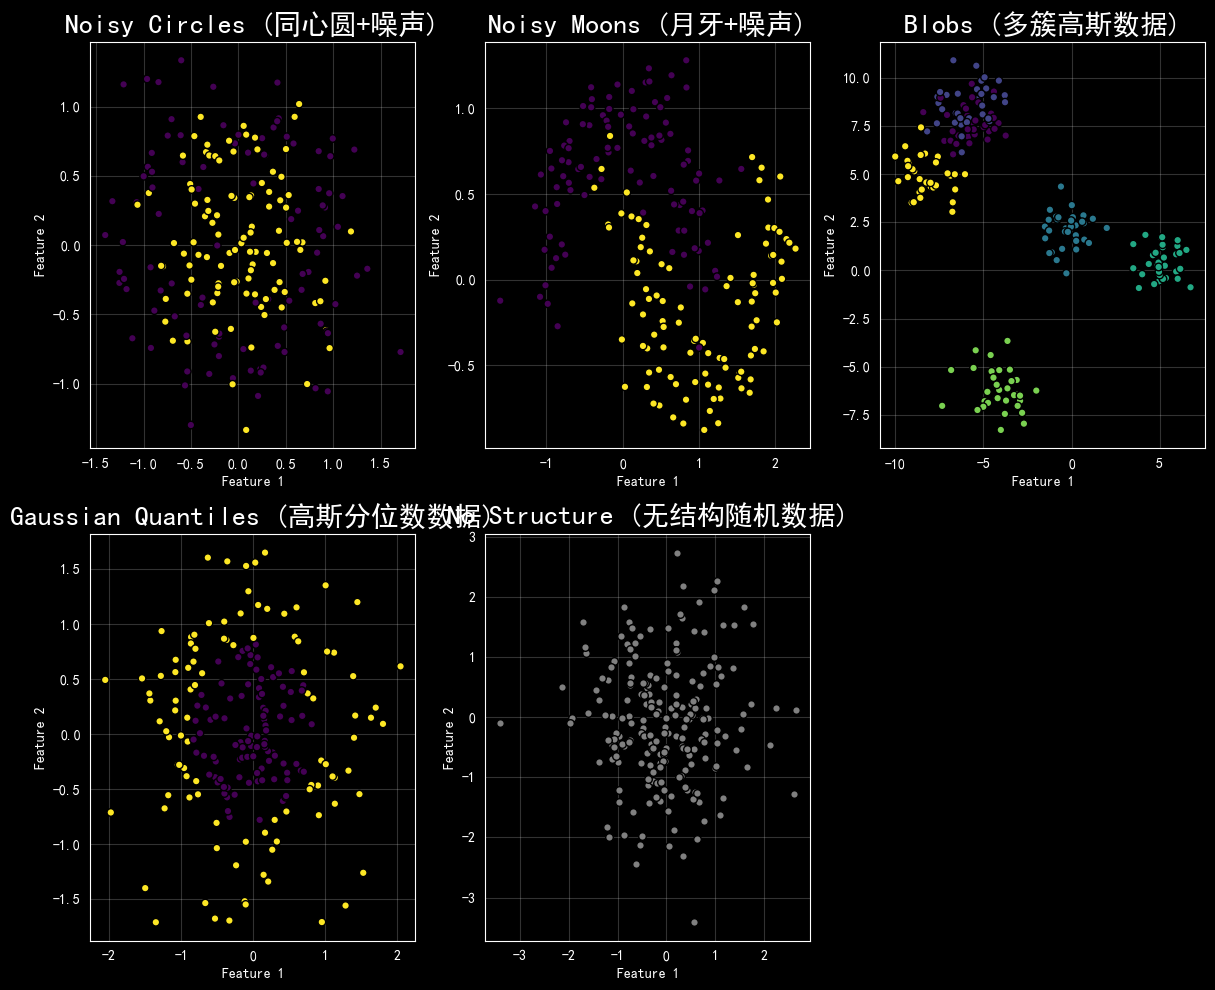

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ------------------------
# 载入数据
# ------------------------
datasets = load_extra_datasets()

datasets_names = [
    "Noisy Circles (同心圆+噪声)",
    "Noisy Moons (月牙+噪声)",
    "Blobs (多簇高斯数据)",
    "Gaussian Quantiles (高斯分位数数据)",
    "No Structure (无结构随机数据)"
]

# ------------------------
# 作图
# ------------------------
plt.figure(figsize=(12, 10))

for i, (dataset, name) in enumerate(zip(datasets, datasets_names), 1):
    X, y = dataset # 每个数据集都是 (X, y)

    plt.subplot(2, 3, i)
    if y.ndim == 1:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=30, edgecolors='k')
    else:
        plt.scatter(X[:, 0], X[:, 1], color="gray", s=30, edgecolors='k')

    plt.title(name, fontsize=20)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [9]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

X的维度为：(2, 400)
Y的维度为：(1, 400)
数据集的数据个数：400个


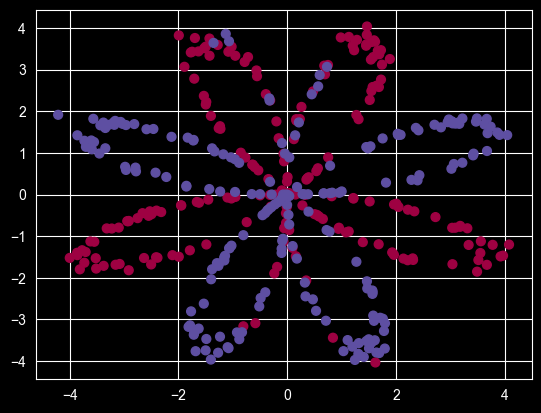

In [13]:
import matplotlib.pyplot as plt
X, Y = load_planar_dataset()

plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

shape_X = X.shape
shape_Y = Y.shape

m = Y.shape[1]

print("X的维度为：" + str(shape_X))
print("Y的维度为：" + str(shape_Y))
print("数据集的数据个数：" + str(m) + "个")

In [14]:
import sklearn
import sklearn.linear_model

clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)


F:\Anaconda_envs\envs\dl\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

In [16]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


C:\Users\www12\AppData\Local\Temp\ipykernel_22224\1590277667.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) +


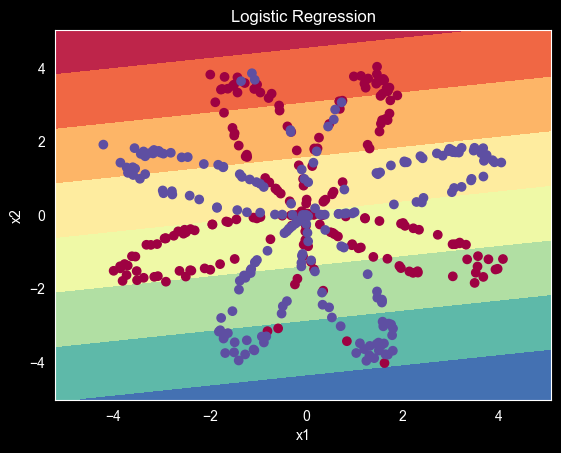

In [19]:
plot_decision_boundary(lambda x: clf.decision_function(x), X, Y)
plt.title("Logistic Regression")
LR_predictions = clf.predict(X.T)
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) +
		np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")